In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import precision_score, recall_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

import xgboost as xgb

import shap

import eli5
from eli5.sklearn import PermutationImportance

from pdpbox import pdp, info_plots 

import warnings
warnings.filterwarnings('ignore')

# The Data

In [2]:
data = pd.read_csv('/home/shaggy/heart.csv')
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [3]:
data.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


# The Model

## Fits a random forest model to the data

In [4]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(['target'], axis=1), 
                                                    data.target, 
                                                    test_size=0.33, 
                                                    random_state=42)

In [4]:
# rf = RandomForestClassifier()
# parameters = {'n_estimators': range(1, 50, 10), 
#               'max_depth': range(2, 20, 2), 
#               'min_samples_leaf': range(1, 15),
#               'min_samples_split': range(2, 15)}

In [5]:
# find best parameters for model
grid_search_clf = GridSearchCV(rf, parameters)
grid_search_clf.fit(X_train, y_train)
grid_search_clf.best_params_

{'max_depth': 10, 'min_samples_leaf': 12, 'min_samples_split': 8, 'n_estimators': 31}


In [5]:
# best clf - лучшая модель
# best_clf = grid_search_clf.best_estimator_
best_clf = RandomForestClassifier(max_depth=10, min_samples_leaf=12, min_samples_split=8,
                       n_estimators=31).fit(X_train, y_train)

In [6]:
y_predict = best_clf.predict(X_test)
y_pred_quant = best_clf.predict_proba(X_test)[:, 1]
y_pred_bin = best_clf.predict(X_test)
y1 = y_test.array
y1

<PandasArray>
[0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0,
 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0,
 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0,
 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
Length: 100, dtype: int64

### Feature importances

In [7]:
feature_importances = best_clf.feature_importances_
feature_importances_df = pd.DataFrame({'features': list(X_train), 'feature_importances': feature_importances})
feature_importances_df.sort_values('feature_importances', ascending=False)

,features,feature_importances
2,cp,0.229278
11,ca,0.185282
12,thal,0.125173
8,exang,0.107575
9,oldpeak,0.104591
7,thalach,0.071065
10,slope,0.064554
1,sex,0.048828
0,age,0.031357
4,chol,0.018598


### Confusion matrix and roc/auc analys

In [8]:
confusion_matrix = confusion_matrix(y1, y_pred_bin)
confusion_matrix

array([[35,  7],
       [ 7, 51]])

In [9]:
total=sum(sum(confusion_matrix))

sensitivity = confusion_matrix[0,0]/(confusion_matrix[0,0]+confusion_matrix[1,0])
print('Sensitivity : ', sensitivity )

specificity = confusion_matrix[1,1]/(confusion_matrix[1,1]+confusion_matrix[0,1])
print('Specificity : ', specificity)

accuracy = (confusion_matrix[0,0] + confusion_matrix[1,1])/total
print('Accuracy : ', accuracy)

recall = confusion_matrix[0,0]/(confusion_matrix[0,0] + confusion_matrix[1,0])
print('Recall : ', recall)

precision = confusion_matrix[0,0]/(confusion_matrix[0,0] + confusion_matrix[0,1])
print('Precision : ', precision)

F = (2 * recall * accuracy)/(recall + accuracy)
print('F : ', F)

Sensitivity :  0.8333333333333334
Specificity :  0.8793103448275862
Accuracy :  0.86
Recall :  0.8333333333333334
Precision :  0.8333333333333334
F :  0.8464566929133859


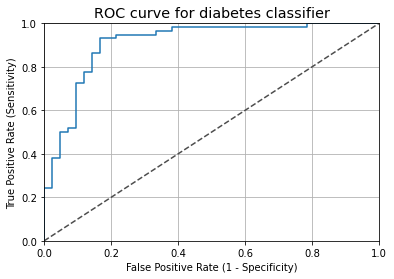

In [10]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_quant)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for diabetes classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [11]:
auc(fpr, tpr)

0.9105090311986863

## Fits a XGBoost model to the data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(['target'], axis=1), 
                                                    data.target, 
                                                    test_size=0.33, 
                                                    random_state=42)

In [5]:
gbm = xgb.XGBClassifier().fit(X_train, y_train)
xgb_predictions = gbm.predict(X_test)
gbm.get_booster().get_fscore()

[10:40:42] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


{'ca': 53,
 'thal': 35,
 'oldpeak': 60,
 'trestbps': 67,
 'age': 106,
 'exang': 14,
 'cp': 40,
 'thalach': 61,
 'slope': 30,
 'chol': 74,
 'restecg': 26,
 'sex': 16}

In [12]:
y_predict = gbm.predict(X_test)
y_pred_quant = gbm.predict_proba(X_test)[:, 1]
y_pred_bin = gbm.predict(X_test)
y1 = y_test.array

### Feature importances

In [6]:
feature_importances_gbm = gbm.feature_importances_
feature_importances_df = pd.DataFrame({'features': list(X_train), 'feature_importances': feature_importances_gbm})
feature_importances_df.sort_values('feature_importances', ascending=False)

,features,feature_importances
2,cp,0.185747
11,ca,0.178252
12,thal,0.175701
8,exang,0.138032
10,slope,0.069468
9,oldpeak,0.066473
0,age,0.037107
7,thalach,0.033874
4,chol,0.031739
1,sex,0.031042


### Confusion matrix and roc/auc analys

In [7]:
confusion_matrix_xgb = confusion_matrix(y_test.array, xgb_predictions)
confusion_matrix_xgb

array([[34,  8],
       [10, 48]])

In [13]:
total=sum(sum(confusion_matrix_xgb))

sensitivity = confusion_matrix_xgb[0,0]/(confusion_matrix_xgb[0,0]+confusion_matrix_xgb[1,0])
print('Sensitivity : ', sensitivity )

specificity = confusion_matrix_xgb[1,1]/(confusion_matrix_xgb[1,1]+confusion_matrix_xgb[0,1])
print('Specificity : ', specificity)

accuracy = (confusion_matrix_xgb[0,0] + confusion_matrix_xgb[1,1])/total
print('Accuracy : ', accuracy)

recall = confusion_matrix_xgb[0,0]/(confusion_matrix_xgb[0,0] + confusion_matrix_xgb[1,0])
print('Recall : ', recall)

precision = confusion_matrix_xgb[0,0]/(confusion_matrix_xgb[0,0] + confusion_matrix_xgb[0,1])
print('Precision : ', precision)

F = (2 * recall * accuracy)/(recall + accuracy)
print('F : ', F)

Sensitivity :  0.7727272727272727
Specificity :  0.8571428571428571
Accuracy :  0.82
Recall :  0.7727272727272727
Precision :  0.8095238095238095
F :  0.7956621004566209


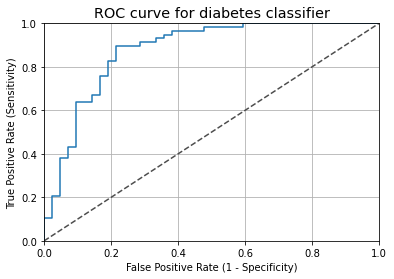

In [14]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_quant)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for diabetes classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [15]:
auc(fpr, tpr)

0.8768472906403941

### Permutation Importance

Permutation Importance работает для многих оценок scikit-learn. Идея проста: Произвольным образом переставить или перетасовать один столбец в наборе датасета валидации, оставив все остальные столбцы нетронутыми. Признак считается «важным», если точность модели падает и его изменение вызывает увеличение ошибок. С другой стороны, признак считается «неважным», если перетасовка его значений не влияет на точность модели.

In [16]:
perm = PermutationImportance(gbm, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.0880 ± 0.0233,cp
0.0820 ± 0.0427,ca
0.0720 ± 0.0294,thal
0.0460 ± 0.0098,slope
0.0440 ± 0.0431,thalach
0.0440 ± 0.0299,age
0.0280 ± 0.0150,sex
0.0240 ± 0.0299,oldpeak
0.0140 ± 0.0299,exang
0.0120 ± 0.0150,restecg


### Partial Dependence Plots

Partial Dependence Plots (графики частичной зависимости или же PDP, PD-графики) показывают незначительное влияние одного или двух признаков на прогнозируемый результат модели машинного обучения ( J. H. Friedman 2001 ). PDP может показать связь между целью и выбранными признаками с помощью 1D или 2D графиков.

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


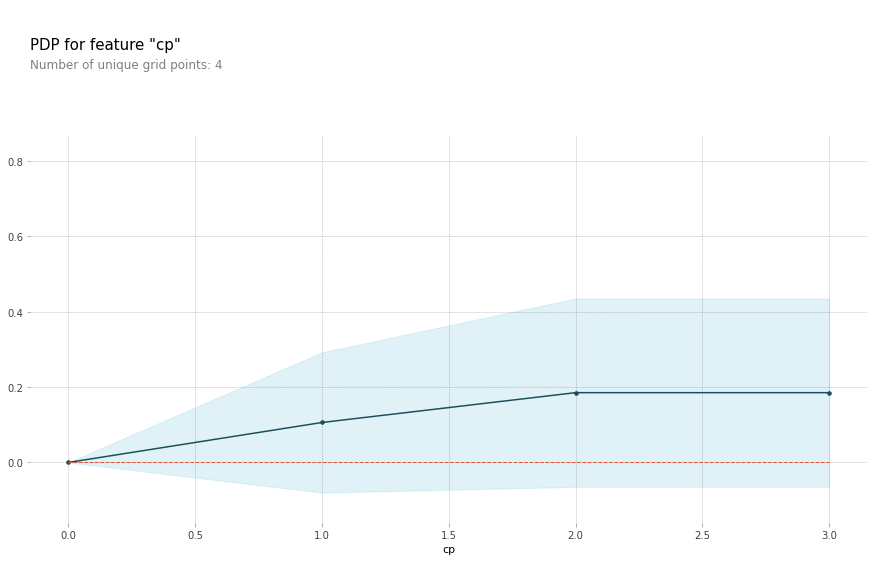

In [21]:
base_features = data.columns.values.tolist()
base_features.remove('target')

feat_name = 'cp'
pdp_dist = pdp.pdp_isolate(model=gbm, dataset=X_test, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

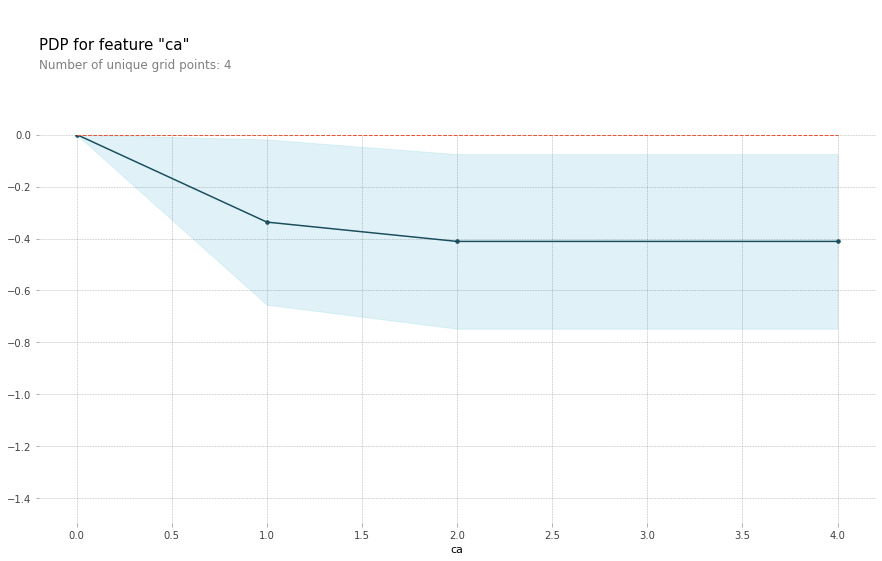

In [25]:
base_features = data.columns.values.tolist()
base_features.remove('target')

feat_name = 'ca'
pdp_dist = pdp.pdp_isolate(model=gbm, dataset=X_test, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

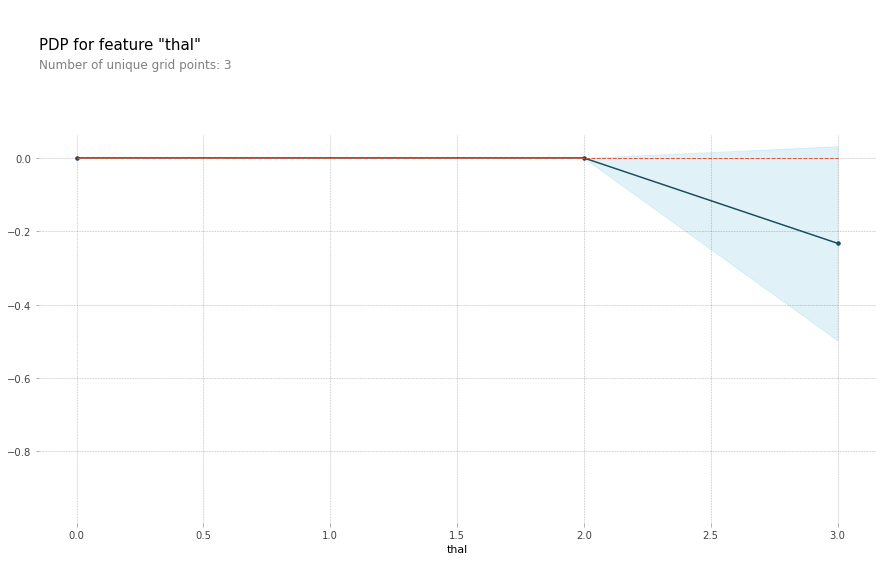

In [24]:
base_features = data.columns.values.tolist()
base_features.remove('target')

feat_name = 'thal'
pdp_dist = pdp.pdp_isolate(model=gbm, dataset=X_test, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

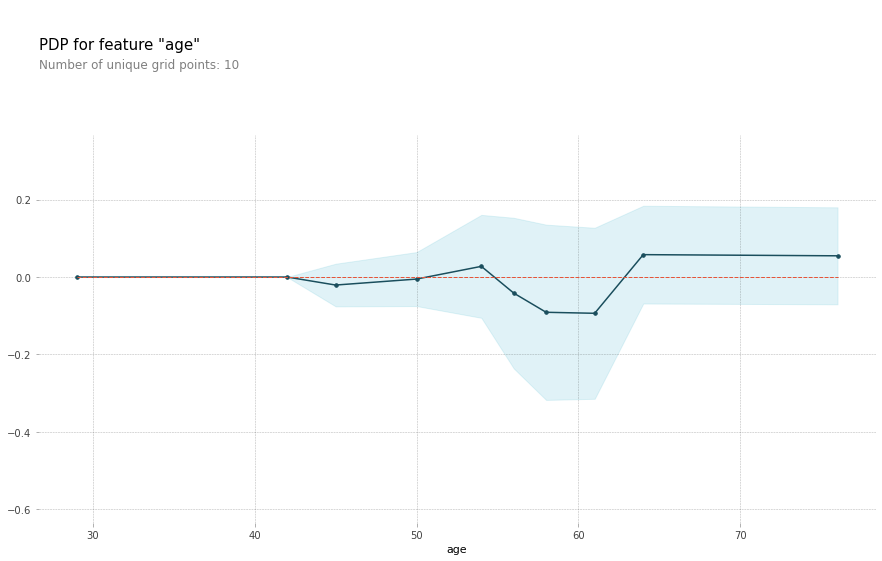

In [23]:
base_features = data.columns.values.tolist()
base_features.remove('target')

feat_name = 'age'
pdp_dist = pdp.pdp_isolate(model=gbm, dataset=X_test, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

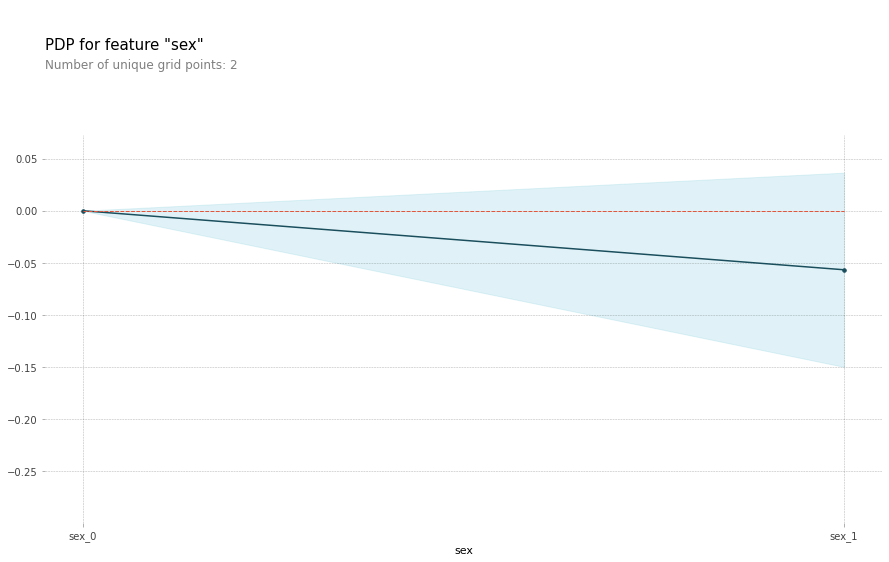

In [22]:
base_features = data.columns.values.tolist()
base_features.remove('target')

feat_name = 'sex'
pdp_dist = pdp.pdp_isolate(model=gbm, dataset=X_test, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

### Heatmap
проверка корреляций является важной частью процесса анализа поисковых данных. Этот анализ является одним из методов, используемых для определения того, какие функции больше всего влияют на целевую переменную, и, в свою очередь, используются при прогнозировании этой целевой переменной. 

<AxesSubplot:title={'center':'Pearson Correlation of Features'}>

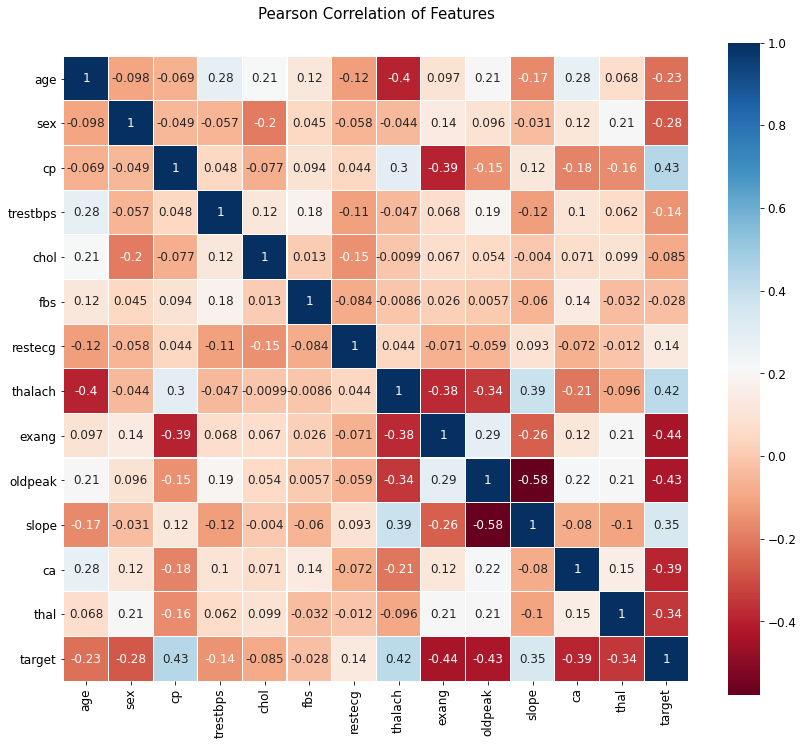

In [28]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(data.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

### SHAP-значения

SHAP расшифровывается как SHapley Additive explanation. Этот метод помогает разбить на части прогноз, чтобы выявить значение каждого признака. Он основан на Векторе Шепли, принципе, используемом в теории игр для определения, насколько каждый игрок при совместной игре способствует ее успешному исходу. Как правило, нахождение компромисса между точностью и интерпретируемостью может оказаться трудным балансом, однако значения SHAP могут обеспечить и то, и другое.

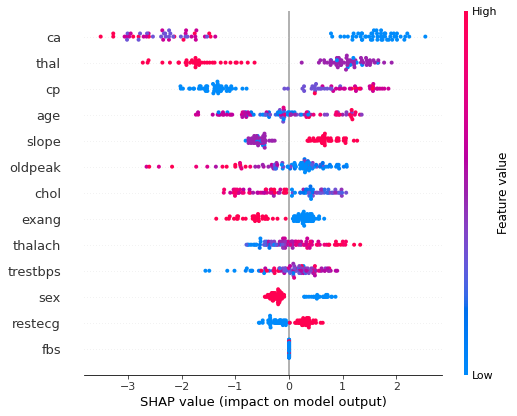

In [38]:
explainer = shap.TreeExplainer(gbm)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)

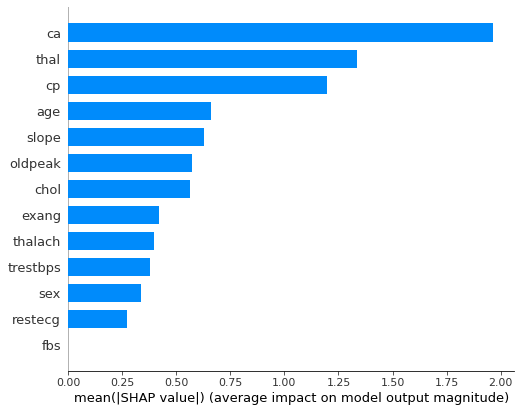

In [40]:
shap.summary_plot(shap_values, X_test, plot_type="bar")